# Storing and displaying images

This notebook shows how to use NV-Ingest's extract and store tasks to extract images, charts, and tables from a multimodal pdf, store them in a Minio object store, and display them

**Note:** In order to run this notebook, you'll need to have the NV-Ingest microservice running along with all of the other included microservices. To do this, make sure all of the services are uncommented in the file: [docker-compose.yaml](https://github.com/NVIDIA/nv-ingest/blob/main/docker-compose.yaml) and follow the [quickstart guide](https://github.com/NVIDIA/nv-ingest?tab=readme-ov-file#quickstart) to start everything up. You'll also need to have the NV-Ingest python client installed as demonstrated [here](https://github.com/NVIDIA/nv-ingest?tab=readme-ov-file#step-2-installing-python-dependencies).

To start, make sure the minio python client is installed and up to date

In [ ]:
pip install -qU minio

Then, we'll use NV-Ingest's Ingestor interface extract the images, tables, and charts from a test pdf and store them in a minio bucket

In [18]:
from nv_ingest_client.client import Ingestor

#TODO: update with your minio access key and secret key
MINIO_ACCESS_KEY="minioadmin"
MINIO_SECRET_KEY="minioadmin"

ingestor = (
    Ingestor(message_client_hostname="localhost")
    .files("../data/multimodal_test.pdf")
    .extract(
        extract_text=False,
        extract_tables=True,
        extract_images=True,
    ).store(
        structured=True,
        images=True,
        store_method="minio",
        access_key=MINIO_ACCESS_KEY, 
        secret_key=MINIO_SECRET_KEY,
    )
)

results = ingestor.ingest()

In [7]:
results

[[{'document_type': 'image',
   'metadata': {'chart_metadata': None,
    'content': 'iVBORw0KGgoAAAANSUhEUgAAAdQAAADZCAYAAACZzsEGAAA9qUlEQVR4nO3daXQTZ57H+29ply3Jm2yDN2y8YGwIZjPB7GEnhJAOJGlIoJNu0tOZc++Z7hd35pz7as69L+4sZ3pNp3uSmU536E5I6IQECPu+GQM2ZrcNNl7wvsqyrL3uC8bqEEIgICNg/p9zcoKlUtVTj0r66Xmq6nkUVVVVhBBCCPFANJEugBBCCPEkkEAVQgghwkACVQghhAgDCVQhvoGqqvh8Ph7VSwzupXxDywghHg4JVPHEUlWViooK3nnnHf7t3/6Nbdu24XK57um1PT09/PrXvyYYDH7n7Z4/f55AIPCdX/dddHZ28vbbb99SvmAwyLVr1+jv7w8t8+tf//qe1ufxeHjvvffwer3DUl4Ah8PBtWvXhm39QkSaBKp4Yp0/f56dO3cyf/581q5dS3t7O/v27Qu16oLBIH6//5bXqKqK3+9HVVUGBgZue/zrvunxP//5z3g8nlseG1rnN/mmcgw9/vVgHtpeMBi87cdBMBhkz549tLS0hJYdGBj4xjJ+dT8BdDodc+fORafTfWMZ77YvgUDgth8fXy//jRs32LNnz13XL8Tj6u6fHiEeUydPnmTBggXk5uaiKApr1qwJdYFeunSJXbt24XK5SElJ4eWXX2ZgYIBNmzYxODiI2WwOhWJfXx8ffvgh/f39WCwW/H4/b731Fh0dHWzcuBGfz0dcXBzr1q3j448/pq2tjXfeeYfc3FxKSkr45JNPcLlcmEwmXnnlFRISEkJlPHXqFIcPH8blcjFmzBhWrlzJ5cuXOXHiBG63m+7ububMmcO8efPo6Ojg448/xuPxYDKZbmlN+v1+vvjiCy5cuEBnZyeZmZksWrSI7u5u3n77bTo7O8nOzmbt2rX

Now, we have a listt of results containing our extracted images, charts, and tables encoded in base64. We can display one of the the base64 encoded images above by converting it into a BytesIO object and displying it with PIL

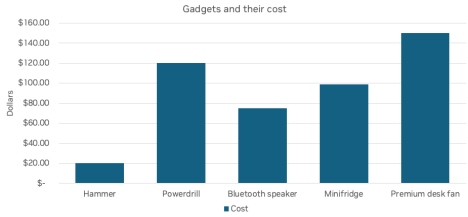

In [11]:
from PIL import Image
from io import BytesIO
import base64

image = Image.open(BytesIO(base64.b64decode(results[0][0]['metadata']['content'])))
image.show() 

Also, our images are now stored in the `nv-ingest` bucket in minio. To browse the uploaded images we can go to the objects tab in the Minio console running at [http://localhost:9001](http://localhost:9001) or wherever the Minio console is running. We can also download and display the images using the Minio python client. First, we'll create a client and connect it to our Minio microservice

In [12]:
from minio import Minio

minio_client = Minio(
    "localhost:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)

Then, we'll get the name of the result folder which is just the url safe version of the name of the file that we performed the extraction on

In [14]:
from urllib.parse import quote

bucket = "nv-ingest"
results_folder = quote("../data/multimodal_test.pdf", safe="")

Next, we can use our bucket name and folder name to get all the objects that were extracted from our pdf

In [15]:
objects = minio_client.list_objects(bucket, prefix=results_folder+"/")

Finally, we can use the minio client to get the url for each image and then download them and display them in our notebook

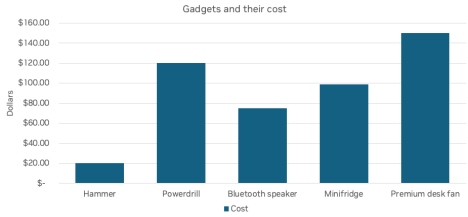

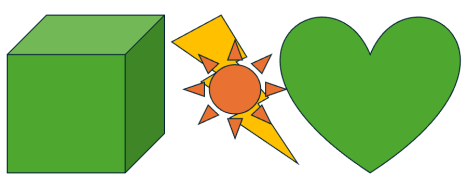

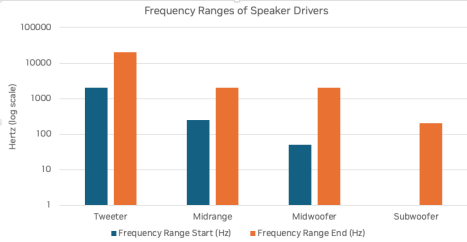

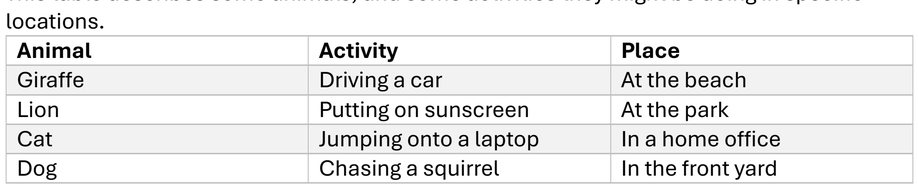

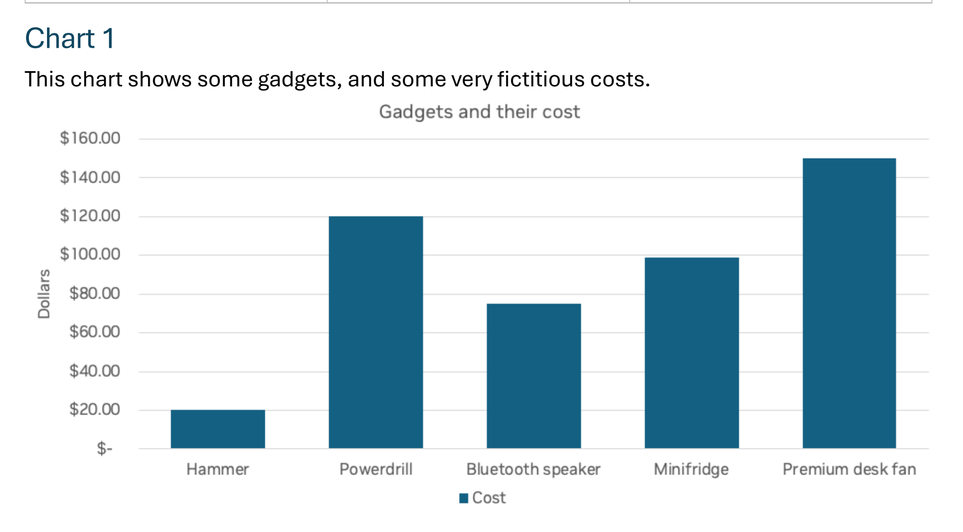

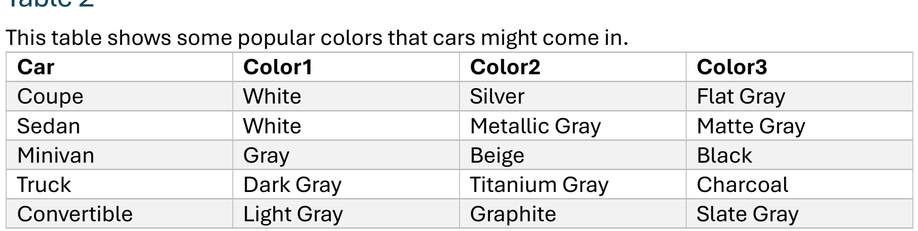

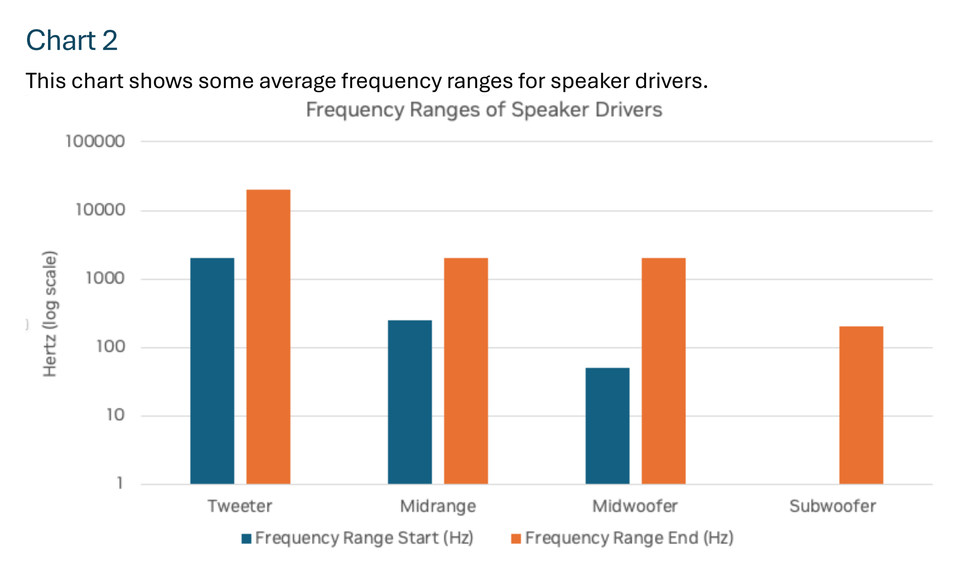

In [16]:
import requests

for obj in objects:
    url = minio_client.presigned_get_object(bucket, obj.object_name)
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image.show() 